In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/EE541"

[Errno 2] No such file or directory: '/content/drive/My Drive/EE541_Project'
/content


In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
#import torchaudio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = pd.DataFrame(np.load("/content/drive/My Drive/EE541/dataset_melspectrogram.npy",allow_pickle= True))
data.columns = ['feature', 'label']


In [9]:
X = np.array(data.feature.tolist())
y = np.array(data.label.tolist())

# Split the data into 70% train and 30% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the remaining 30% into half to get 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [10]:
label_dict = {'dog_bark' : 0, 'children_playing' : 1, 'car_horn' : 2, 'air_conditioner' : 3,
       'street_music' : 4, 'gun_shot' : 5, 'siren' : 6, 'engine_idling' : 7, 'jackhammer' : 8,
       'drilling' : 9}

ly = []
lvay = []
ltesty = []

for i in y_train:
    ly.append(label_dict[i])

for i in y_val:
    lvay.append(label_dict[i])

for i in y_test:
    ltesty.append(label_dict[i])

In [11]:
X = torch.from_numpy(X_train)
val_x = torch.from_numpy(X_val)
test_x = torch.from_numpy(X_test)
y = torch.from_numpy(np.array(ly))
val_y = torch.from_numpy(np.array(lvay))
test_y = torch.from_numpy(np.array(ltesty))

print(y)

tensor([3, 9, 1,  ..., 3, 6, 6])


In [12]:
X.shape

torch.Size([6112, 40])

In [13]:
y.shape

torch.Size([6112])

In [14]:
from torch.utils.data import TensorDataset

train_set = TensorDataset(X.unsqueeze(1), y)
val_set = TensorDataset(val_x.unsqueeze(1), val_y)
test_set = TensorDataset(test_x.unsqueeze(1), test_y)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [16]:

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 128, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv2 = nn.Conv1d(1, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.avgPool = nn.AvgPool1d(40) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 10)

    def forward(self, x):
        #x = self.conv1(x)
        #x = F.relu(self.bn1(x))
        #x = self.pool1(x)
        #print(x.shape)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        #x = self.pool2(x)
        #print(x.shape)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        #x = self.pool3(x)
        #print(x.shape)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        #x = self.pool4(x)
        #print(x.shape)
        x = self.avgPool(x)
        #print(x.shape)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

model = Net()
model.to(device)
print(model)

Net(
  (conv2): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgPool): AvgPool1d(kernel_size=(40,), stride=(40,), padding=(0,))
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


In [18]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [19]:
def train(model, epoch):
    model.train()
    correct = 0
    total = 0
    total_loss = 0  # Initialize total loss for the epoch

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        data = data.requires_grad_()  # Set requires_grad to True for training
        output = model(data)
        output = output.permute(1, 0, 2)  # Original output dimensions are batchSizex1x10
        target = target.to(torch.int64)
        loss = F.nll_loss(output[0], target)  # The loss function expects a batchSizex10 input
        total_loss += loss.item()  # Accumulate the loss
        loss.backward()
        optimizer.step()

        # Calculate correct predictions
        pred = output.max(2)[1]  # Get the index of the max log-probability
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    # Calculate average loss and accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    print('Train Epoch: {} \tAverage Loss: {:.4f}\tAccuracy: {:.2f}%'.format(
        epoch, average_loss, train_accuracy))
    return average_loss, train_accuracy


In [20]:
def val(model, epoch):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():  # No need to track gradients during validation
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            output = output.permute(1, 0, 2)
            val_loss += F.nll_loss(output[0], target, reduction='sum').item()  # Sum up batch loss
            pred = output.max(2)[1]  # Get the index of the max log-probability
            correct += pred.eq(target).cpu().sum().item()

    val_loss /= len(val_loader.dataset)  # Average loss
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return val_loss,  100. * correct / len(val_loader.dataset)


In [21]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
    print('Test set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [22]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, 51):
    train_loss, train_accuracy = train(model, epoch)
    val_loss, val_accuracy = val(model, epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

Train Epoch: 1 	Average Loss: 1.7393	Accuracy: 41.41%

Validation set: Average loss: 1.5311, Accuracy: 630/1310 (48%)

Train Epoch: 2 	Average Loss: 1.4139	Accuracy: 51.59%

Validation set: Average loss: 1.3190, Accuracy: 694/1310 (53%)

Train Epoch: 3 	Average Loss: 1.2742	Accuracy: 55.91%

Validation set: Average loss: 1.2023, Accuracy: 770/1310 (59%)

Train Epoch: 4 	Average Loss: 1.1952	Accuracy: 59.62%

Validation set: Average loss: 1.2063, Accuracy: 758/1310 (58%)

Train Epoch: 5 	Average Loss: 1.1309	Accuracy: 61.55%

Validation set: Average loss: 1.1267, Accuracy: 797/1310 (61%)

Train Epoch: 6 	Average Loss: 1.0735	Accuracy: 63.71%

Validation set: Average loss: 1.0622, Accuracy: 804/1310 (61%)

Train Epoch: 7 	Average Loss: 1.0403	Accuracy: 64.38%

Validation set: Average loss: 1.1084, Accuracy: 805/1310 (61%)

Train Epoch: 8 	Average Loss: 1.0113	Accuracy: 65.25%

Validation set: Average loss: 1.0405, Accuracy: 829/1310 (63%)

Train Epoch: 9 	Average Loss: 0.9662	Accuracy: 6

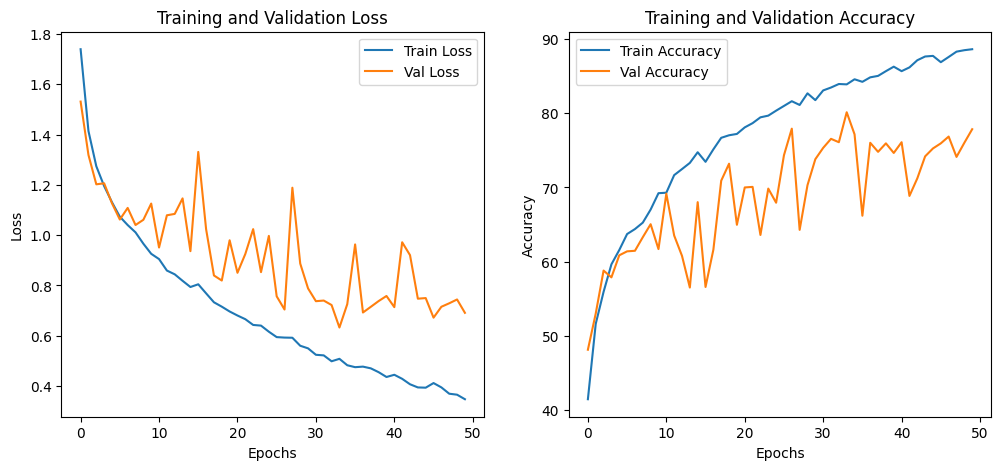

In [23]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [24]:
import pickle
with open('CNN_Train_LOSS.pkl', 'wb') as file:
    pickle.dump(train_losses, file)
with open('CNN_VAL_LOSS.pkl', 'wb') as file:
    pickle.dump(val_losses, file)
with open('CNN_Train_AUC.pkl', 'wb') as file:
    pickle.dump(train_accuracies, file)
with open('CNN_VAL_AUC.pkl', 'wb') as file:
    pickle.dump(val_accuracies, file)